In [2]:
from keras.models import load_model
model = load_model('vgg16.h5')

Using TensorFlow backend.


In [14]:
from keras import backend as K

K.set_image_dim_ordering('th')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 64, 114, 114)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 112, 112)     73856     
__________

In [17]:
from keras.models import Model
from keras.layers.convolutional import UpSampling2D, ZeroPadding2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import SGD
m = Model(inputs = model.inputs, outputs = model.layers[16].output)
m.trainable = False
x = model.inputs
x = m(x)

x = UpSampling2D(2)(x)
x = ZeroPadding2D(1)(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu') (x)
x = ZeroPadding2D(1)(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu') (x)

x = UpSampling2D(2)(x)
x = ZeroPadding2D(1)(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu') (x)
x = ZeroPadding2D(1)(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = Activation('relu') (x)

x = UpSampling2D(2)(x)
x = ZeroPadding2D(1)(x)
x = Conv2D(2, 3)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

m2 = Model(inputs = model.inputs, outputs = x)
sgd = SGD(lr=1.)
m2.compile(loss='binary_crossentropy', optimizer='sgd')

In [18]:
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2_input (Inpu (None, 3, 224, 224)       0         
_________________________________________________________________
model_5 (Model)              (None, 256, 28, 28)       1735488   
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 256, 56, 56)       0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 256, 58, 58)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 56, 56)       295040    
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 56, 56)       224       
_________________________________________________________________
activation_11 (Activation)   (None, 128, 56, 56)       0         
__________

In [7]:
from scipy.misc import imresize
import numpy as np

def preprocess(mri_slice,tile=True):
    img0 = imresize(mri_slice, (224,224))
    img0.resize((img0.shape[0],img0.shape[1],1))
    if tile: img0 = np.tile(img0,3)
    img0 = img0.transpose((2,0,1))
    return np.expand_dims(img0, axis=0)
def preprocess_label(labels):
    labels = imresize(labels, (224,224))
    pos = np.where(labels==1)
    new_labels = np.zeros([labels.shape[0],labels.shape[1],2])
    new_labels[:,:,0] = 1
    new_labels[pos[0],pos[1],0] = 0
    new_labels[pos[0],pos[1],1] = 1
    new_labels = new_labels.transpose((2,0,1))
    return np.expand_dims(new_labels, axis=0)

In [9]:
# Get image data w/ nibabel
import nibabel as nib
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))    
mri_data = scale(get_data('../data/case_001_2.nii.gz')).transpose((2,0,1))
labelled_data = get_data('../data/case_001_labels.nii.gz').transpose((2,0,1))

In [10]:
label_sums = labelled_data.sum(axis=(1,2))
x_train_arr = []
y_train_arr = [] 
for mri_slice, labels in zip(mri_data, labelled_data):
#for mri_slice, labels in zip(mri_data[np.where(label_sums>0)], labelled_data[np.where(label_sums>0)]):
    x_train_arr.append(preprocess(mri_slice))
    y_train_arr.append(preprocess_label(labels))
x_train = np.vstack(x_train_arr)
y_train = np.vstack(y_train_arr)

In [19]:
initial = 0
epochs = 10
for i in range(2):
    m2.fit(x_train,y_train,epochs=initial+epochs, initial_epoch=initial,batch_size=3)
    initial+=epochs

Epoch 1/10
33/33 [==============================] - 5s - loss: 2.7579      
Epoch 2/10
33/33 [==============================] - 3s - loss: 2.7182     

In [58]:
img.max()

0.9999994

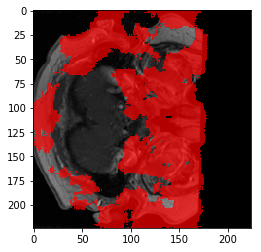

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

predict_slide = 2
img= m2.predict(preprocess(mri_data[predict_slide])).squeeze()
pos = np.where(np.argmax(img, axis=0)>0)
img1 = np.zeros((img.shape[1],img.shape[2]))
img1[pos[0],pos[1]] = 1
fig, ax = plt.subplots(1,1)
ax.imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
ax.imshow(np.ma.masked_where(img1<.5, img1),alpha=.7,cmap=plt.cm.autumn, interpolation='none')
